# FM 5031 Quantitative Risk Management 

## Homework for Week 2, John Dodson, September 20, 2021

### Student - Wei Quan

In [17]:
#Improve filter
import warnings
warnings.filterwarnings('ignore')

### Problems

I have assembled some daily closing prices for the (European-style) NASDAQ-100 index option expiring
on September 17, 2021 in https://www-users.cse.umn.edu/~dodso013/fm503/docs/fall2ex.html.
N.B.: Market data can be inconsistent. In reality, the price of a commodity—even in a liquid market—
depends on whether you are buying or selling, and on how much. Also, disseminating and processing the
order book takes time; so quotes may not be exactly synchronous, even at the close of the trading session.
We can attempt to determine a snapshot of prices for historical analysis; but sometimes the result is not
satisfactory.

1. Our calculation depends on p(K) being a non-decreasing function. Since the provided data do not
strictly satisfy this requirement, explain how will you modify or filter the data to make it usable.
(2 points)

Refer to code below, I validate option prices each day. Per a specific date, option premium for put should increase with strike given all other inputs are the same. When option premium with current strike is smaller than previous max premium, then the option price will be marked as invalid. The record for all days (the row) with same strike will be marked as invalid as long as there is one invalid price. This is a little bit too aggressive, an alternative solution can be mark the price as invalid only for specific date.

The cleanup approach reduce available strikes (row) from 494 to 453. This will make Ft greater or equal to zero.

2. Estimate the entropy of the terminal value of the index for the days in provided data. (6 points)

Entropy calculatioin can be found from the code below. Just following the fomulas provided in the excersize. I tried two appoaches. One is without extra filter except no negative on Q. The other applied gaussian filter on calculated risk neutral probability.

3. Discuss your results. Does it decline each day? (2 points)

Without applying gaussian filter on probabilities, even though in general entropy is declining except the 5th day. See the chart on entropy without filters.

The chart at bottom of the notebook shows the trend when applying gaussian filter on probabilities. The results looks much better.

Ideally, if we can calibrate volatility surface with in the money call and put prices, then calibrated prices can be used to calculate mass function, then $q_{ij}$ and Entropy. The gaussian filter on $q_{ij}$ might not be needed.

In [18]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes import black_scholes
import numpy as np
import datetime

def load_implied():
    fileDt = 'HW2Data/date.csv'
    raw_dates = pd.read_csv(fileDt, sep='\t', lineterminator='\n')
    dfImplied = raw_dates.T
    dfImplied.columns = ['DiscountFactor','Foward','AdjClose'] 
    dfImplied = dfImplied.astype(float)
    dfImplied.index = pd.to_datetime(dfImplied.index)
    return dfImplied

In [19]:
dfImplied = load_implied()
print(dfImplied.index)
print(-np.log(dfImplied.DiscountFactor) / ((datetime.datetime(2021, 9, 17) - dfImplied.index).days/365))
dfImplied


DatetimeIndex(['2021-09-02', '2021-09-03', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10', '2021-09-13', '2021-09-14',
               '2021-09-15', '2021-09-16'],
              dtype='datetime64[ns]', freq=None)
2021-09-02    0.000803
2021-09-03    0.000860
2021-09-07    0.000767
2021-09-08    0.000689
2021-09-09    0.000639
2021-09-10    0.000834
2021-09-13    0.000730
2021-09-14    0.000608
2021-09-15    0.000730
2021-09-16    0.000730
dtype: float64


,DiscountFactor,Foward,AdjClose
2021-09-02,0.999967,15600.62,15604.25
2021-09-03,0.999967,15651.48,15652.86
2021-09-07,0.999979,15674.28,15675.76
2021-09-08,0.999983,15618.30,15620.85
2021-09-09,0.999986,15558.07,15561.05
2021-09-10,0.999984,15441.58,15440.75
2021-09-13,0.999992,15438.08,15434.50
2021-09-14,0.999995,15383.56,15382.90
2021-09-15,0.999996,15503.40,15503.53
2021-09-16,0.999998,15515.92,15515.91


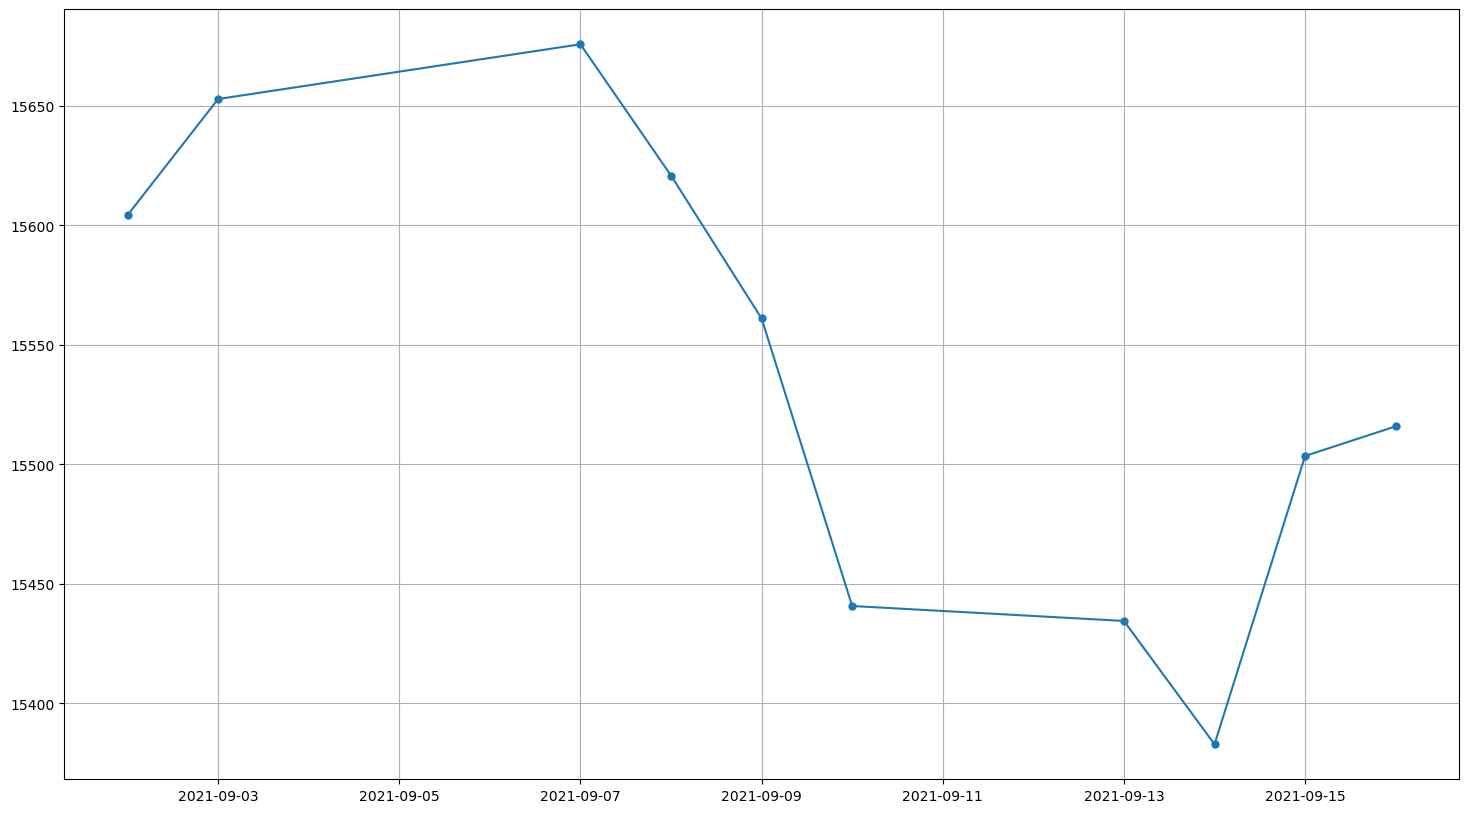

In [20]:
plt.figure(figsize=(18, 10))
plt.plot(dfImplied.index, dfImplied.AdjClose, marker='.', markersize = 10)
plt.grid()
plt.show()

In [21]:
def load_prices():
    filePrices = 'HW2Data/pricebystrike.csv'
    prices = pd.read_csv(filePrices, sep='\t', lineterminator='\n')
    dfPrices = prices.set_index('strike')
    dfPrices = dfPrices.astype(float)
    return dfPrices


In [22]:
dfPrices = load_prices()
impliedDiv = np.zeros(len(dfPrices.columns)) 
impliedDiv[5] = 0.9
impliedDiv[6] = 4.6
impliedDiv[7] = 0.9
impliedDiv[8] = 0.2
impliedDiv[9] = 0.2
impliedDiv
dfRate = -np.log(dfImplied.DiscountFactor) / ((datetime.datetime(2021, 9, 17) - dfImplied.index).days/365)

In [23]:
#dfRate[datetime.datetime(2021, 9, 16)]
#impliedDiv
#test black_scholes library
print(black_scholes('c',100,90,.5,.01,.2))
print(iv(12.11158,100,90,.5,.01,'c'))

12.11158143496968
0.19999992693076693


filtered 8 points on date 2021-09-02
filtered 13 points on date 2021-09-03
filtered 12 points on date 2021-09-07
filtered 9 points on date 2021-09-08
filtered 17 points on date 2021-09-09
filtered 9 points on date 2021-09-10
filtered 15 points on date 2021-09-13
filtered 24 points on date 2021-09-14
filtered 19 points on date 2021-09-15
filtered 11 points on date 2021-09-16


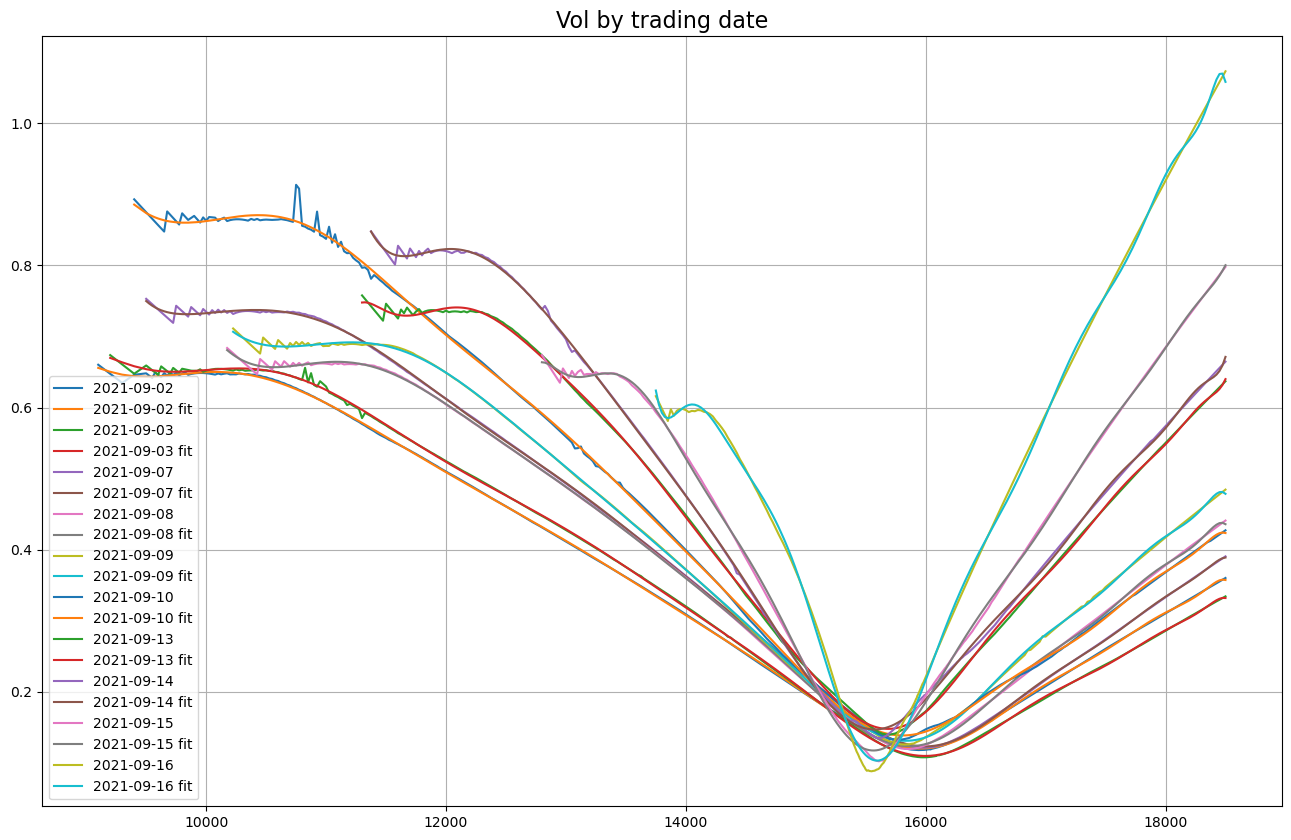

In [24]:
#for dt in dfPrices.columns:
def clean_up(dfPrices, dfImplied, impliedDiv):
    #init return dataframes    
    dfPricesCalib = pd.DataFrame(0, columns=dfPrices.columns, index=dfPrices.index)
    dfImpliedVol = pd.DataFrame(0, columns=dfPrices.columns, index=dfPrices.index)
    dfFilter = pd.DataFrame(False, columns=dfPrices.columns, index=dfPrices.index)
    
    ind = 0
    
    plt.figure(figsize=(16, 10))
    for dt in dfPrices.columns:
        price_date = dt
        dt_price_date = datetime.datetime.strptime(price_date, "%Y-%m-%d")
        dfIV = dfPrices[[price_date]]#[dfPrices.iloc[:,0]>0]
        dfIV = dfIV[dfIV.iloc[:,0]>0]
        dfIV.columns=[[price_date]]
        dfIV['IV'] = 0
        np_price = dfIV.iloc[:,0].to_numpy()
        S = dfImplied.AdjClose[dt_price_date] + impliedDiv[ind]
        flag = 'p'
        t = (datetime.datetime(2021, 9, 17) - dt_price_date).days/365
        r = dfRate[dt_price_date]
        for index, row in dfIV.iterrows():
            dfIV.loc[index,'IV'] = iv(row[0],S,index,t,r,flag)
        dfIV.columns = dfIV.columns.get_level_values(0)
        plt.plot(dfIV.index, dfIV.IV, label=dt)    
        fx = np.poly1d(np.polyfit(dfIV.index, dfIV.IV, 50))
        fxv = fx(dfIV.index)
        fpv = np.zeros(len(fxv))
        for ix in np.arange(len(fxv)):
            xiv = fxv[ix]
            index = dfIV.index[ix]
            fpv[ix] = black_scholes(flag,S,index,t,r,xiv)
        mu = np.mean(fxv - dfIV.IV)
        std = np.std(fxv - dfIV.IV)
        filter = np.abs(fxv - dfIV.IV) > 2*std
        print("filtered {} points on date {}".format(sum(filter), dt))
        fit_label = "{} fit".format(dt)
        dfImpliedVol[dt] = pd.Series(data=fxv, index=dfIV.index)
        dfPricesCalib[dt] = pd.Series(data=fpv, index=dfIV.index)
        
        dfFilter[dt] = pd.Series(data=(np.abs(fxv - dfIV.IV) > 2*std), index=dfIV.index)
        plt.plot(dfIV.index, fxv, label=fit_label)
        ind = ind + 1
    plt.title('Vol by trading date', fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()
    return [dfPricesCalib, dfImpliedVol, dfFilter]
[dfPricesCalib, dfImpliedVol, dfFilter] = clean_up(dfPrices, dfImplied, impliedDiv)

In [14]:
#print(fxv[-10:])
#print(dfIV.IV[-10:])
#print(np.abs(fxv - dfIV.IV)[0:10])
#print((np.abs(fxv - dfIV.IV)>2*std)[0:10])
#print(np.sum(np.abs(fxv - dfIV.IV)>2*std))
#print(std)

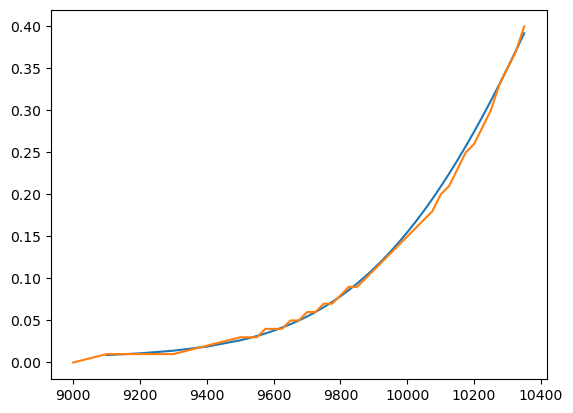

In [25]:
upper = 40
plt.plot(dfPricesCalib.index[0:upper], dfPricesCalib['2021-09-02'][0:upper])
plt.plot(dfPrices.index[0:upper], dfPrices['2021-09-02'][0:upper])
plt.show()

In [16]:
dfPricesCalib['2021-09-02'][0:upper]
dfFilter['2021-09-02'][0:upper]

strike
9000       NaN
9100      True
9200     False
9300      True
9400     False
9500      True
9525     False
9550     False
9575      True
9600     False
9625     False
9650      True
9675     False
9700      True
9725     False
9750     False
9775     False
9800     False
9825     False
9850     False
9875     False
9900     False
9925     False
9950     False
9975     False
10000    False
10025    False
10050    False
10075     True
10100    False
10125     True
10150    False
10175    False
10200    False
10225    False
10250    False
10275    False
10300    False
10325    False
10350    False
Name: 2021-09-02, dtype: object

In [ ]:
#dfFinal = dfMax.copy()
dfFinal = dfPricesCalib.copy()
#arrF = np.zeros((dfFinal.shape[0]-1)*dfFinal.shape[1]).reshape((dfFinal.shape[0]-1), dfFinal.shape[1])
#arrQ = np.zeros((dfFinal.shape[0]-2)*dfFinal.shape[1]).reshape((dfFinal.shape[0]-2), dfFinal.shape[1])

In [ ]:
def calcF(dfFinal):
    arrF = np.zeros((dfFinal.shape[0]-1)*dfFinal.shape[1]).reshape((dfFinal.shape[0]-1), dfFinal.shape[1])
    di = 0
    for dt in dfFinal.columns:
        dfFt = dfFinal[dt]
        ki = 0
        discountFactor = dfImplied.DiscountFactor[dt]
        for sk in dfFt.index[0:-1]:
            ftKt = (dfFt.iloc[ki+1] - dfFt.iloc[ki])/discountFactor/(dfFt.index[ki+1]-dfFt.index[ki]) 
            if ftKt < 0:
                ftKt = 0
            arrF[ki, di] = ftKt
            ki = ki+1
        di = di+1
    return arrF

In [ ]:
def calcQ(arrF, dfFinal, applyFilter):
   #Calculate Q Matrix
   arrQ = np.zeros((dfFinal.shape[0]-2)*dfFinal.shape[1]).reshape((dfFinal.shape[0]-2), dfFinal.shape[1])
   di = 0
   for dt in np.arange(arrF.shape[1]):
      arrFSmooth =   gaussian_filter1d(arrF[:,dt], sigma=5) if applyFilter else arrF[:,dt]
      for xi in np.arange(arrQ.shape[0]):
         #qij = arrF[xi+1,dt] - arrF[xi,dt]  
         qij = arrFSmooth[xi+1] - arrFSmooth[xi]  
         
         if qij < 0:
            qij = 0
         arrQ[xi ,dt] = qij
   return arrQ

In [ ]:
#Use cleaned data without filter
arrF = calcF(dfFinal)
arrQ = calcQ(arrF, dfFinal, False)
fig, axs = plt.subplots(10, sharex=True, figsize=(15,15))
for dt in np.arange(arrQ.shape[1]):
    #dfQTest = pd.DataFrame(arrQ[:,dt])
    axs[dt].plot(arrQ[:,dt])

In [ ]:
def calcEntropy(arrQ):
    #calculate entropy
    di = 0
    arrH = np.zeros(arrQ.shape[1])
    for dt in np.arange(arrQ.shape[1]):
        aj = arrQ[:,dt][arrQ[:,dt]>0]
        arrH[dt] = (aj*(-np.log(aj))).sum()
    return arrH


In [ ]:
arrH = calcEntropy(arrQ)
print("Etropy without Gaussian filter applied on Q")
print(arrH)
plt.plot(arrH)
plt.show()

In [ ]:
dfEntropy = pd.DataFrame(arrH)
plt.plot(arrH)
plt.show()
#dfEntropy.plot()

In [ ]:
#use filter
rrF = calcF(dfFinal)
arrQ = calcQ(arrF, dfFinal, True)
fig, axs = plt.subplots(10, sharex=True, figsize=(15,15))
for dt in np.arange(arrQ.shape[1]):
    #dfQTest = pd.DataFrame(arrQ[:,dt])
    axs[dt].plot(arrQ[:,dt])
plt.show()

In [ ]:
arrH = calcEntropy(arrQ)
print("Etropy with Gaussian filter applied on Q")
print(arrH)
plt.plot(arrH)
plt.show()

In [10]:
dfPrices

,2021-09-02,2021-09-03,2021-09-07,2021-09-08,2021-09-09,2021-09-10,2021-09-13,2021-09-14,2021-09-15,2021-09-16
strike,,,,,,,,,,
9000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
9100,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
9200,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
9300,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
9400,0.02,0.01,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
18400,2799.29,2748.44,2725.67,2781.65,2841.89,2958.37,2961.9,3016.42,2896.59,2884.08
18425,2824.29,2773.44,2750.67,2806.65,2866.89,2983.37,2986.9,3041.42,2921.59,2909.08
18450,2849.29,2798.43,2775.67,2831.65,2891.89,3008.37,3011.9,3066.42,2946.59,2934.08
